# Application of FRANKEN-Z to Real Data

This notebook demonstrates an application of FRANKEN-Z to S16A **Hyper Suprime-Cam (HSC) Subaru Strategic Program (SSP) survey data**. As the training data includes $\sim\!400,000$ objects that have been **inhomogeneously sampled** (cobbled together from various surveys) with **varying errors** (stochastic backgrounds) and **depths** (collected from wide, deep, and ultra-deep fields) along with **multiple flux measurements** (PSF, Cmodel, and fiber/aperture quantities) and **randomly censored data** (from failed extractions and missing coverage), modeling these data provides many new challenges and opportunities.

We first do preliminary tests to determine what set of features appears most relevant to our purposes, where we compare performance on the individual object level as well as the population level. We then move on to cross-validation testing and Hierarchical Bayesian modeling.

## Setup

Let's initialize the environment.

In [1]:
import sys # system commands
from scipy import stats # statistics
from scipy import special # special functions
from astropy.io import fits # reading fits files

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Importing HSC data...

In [2]:
# load observed data
data=fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/catalogs/hsc_s16a_combined_specz_highq_clean_errsim_train_v1.fits')[1].data
print 'Training objects:',len(data)

Training objects: 373432


Importing FRANKEN-Z config files...

In [3]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])
Nf=filt.NFILTER

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color

Initializing dust attenuation corrections...

In [4]:
aphot=10**(-0.4*c_[data['a_g'],data['a_r'],data['a_i'],data['a_z'],data['a_y']])
print 'Median correction:',median(aphot,axis=0)

Median correction: [ 0.94042301  0.95740581  0.96941328  0.97632635  0.97976404]


Initializing PSF flux...

In [5]:
flux_psf=c_[data['gflux_psf'],data['rflux_psf'],data['iflux_psf'],data['zflux_psf'],data['yflux_psf']]*aphot
err_psf=c_[data['gflux_psf_err'],data['rflux_psf_err'],data['iflux_psf_err'],data['zflux_psf_err'],data['yflux_psf_err']]*aphot
err_psf_wide=c_[data['gflux_psf_err_wide'],data['rflux_psf_err_wide'],data['iflux_psf_err_wide'],
                data['zflux_psf_err_wide'],data['yflux_psf_err_wide']]*aphot
mask_psf=(err_psf>0.)&isfinite(err_psf)
print 'Objects with missing values:',(mask_psf.sum(axis=1)<Nf).sum()

Objects with missing values: 3


Note that in addition to the reported errors, there are also "wide-depth" emulated errors. These are used to ensure that performance on testing folds are homogenized to the same depth to give accurate wide-depth forecasts.

Initializing cmodel flux...

In [6]:
flux_cmodel=c_[data['gcmodel_flux'],data['rcmodel_flux'],data['icmodel_flux'],data['zcmodel_flux'],data['ycmodel_flux']]*aphot
err_cmodel=c_[data['gcmodel_flux_err'],data['rcmodel_flux_err'],data['icmodel_flux_err'],
           data['zcmodel_flux_err'],data['ycmodel_flux_err']]*aphot
err_cmodel_wide=c_[data['gcmodel_flux_err_wide'],data['rcmodel_flux_err_wide'],data['icmodel_flux_err_wide'],
                data['zcmodel_flux_err_wide'],data['ycmodel_flux_err_wide']]*aphot
mask_cmodel=(err_cmodel>0.)&isfinite(err_cmodel)
print 'Objects with missing values:',(mask_cmodel.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Initializing cmodel_dev flux...

In [7]:
flux_cmodel_dev=c_[data['gcmodel_dev_flux'],data['rcmodel_dev_flux'],data['icmodel_dev_flux'],
                   data['zcmodel_dev_flux'],data['ycmodel_dev_flux']]*aphot
err_cmodel_dev=c_[data['gcmodel_dev_flux_err'],data['rcmodel_dev_flux_err'],data['icmodel_dev_flux_err'],
           data['zcmodel_dev_flux_err'],data['ycmodel_dev_flux_err']]*aphot
err_cmodel_dev_wide=c_[data['gcmodel_dev_flux_err_wide'],data['rcmodel_dev_flux_err_wide'],data['icmodel_dev_flux_err_wide'],
                data['zcmodel_dev_flux_err_wide'],data['ycmodel_dev_flux_err_wide']]*aphot
mask_cmodel_dev=(err_cmodel_dev>0.)&isfinite(err_cmodel_dev)
print 'Objects with missing values:',(mask_cmodel_dev.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Initializing cmodel_exp flux...

In [8]:
flux_cmodel_exp=c_[data['gcmodel_exp_flux'],data['rcmodel_exp_flux'],data['icmodel_exp_flux'],
                   data['zcmodel_exp_flux'],data['ycmodel_exp_flux']]*aphot
err_cmodel_exp=c_[data['gcmodel_exp_flux_err'],data['rcmodel_exp_flux_err'],data['icmodel_exp_flux_err'],
           data['zcmodel_exp_flux_err'],data['ycmodel_exp_flux_err']]*aphot
err_cmodel_exp_wide=c_[data['gcmodel_exp_flux_err_wide'],data['rcmodel_exp_flux_err_wide'],data['icmodel_exp_flux_err_wide'],
                data['zcmodel_exp_flux_err_wide'],data['ycmodel_exp_flux_err_wide']]*aphot
mask_cmodel_exp=(err_cmodel_exp>0.)&isfinite(err_cmodel_exp)
print 'Objects with missing values:',(mask_cmodel_exp.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Initializing afterburner flux...

In [9]:
flux_afterburner=c_[data['gparent_flux_convolved_2_1'],data['rparent_flux_convolved_2_1'],data['iparent_flux_convolved_2_1'],
                   data['zparent_flux_convolved_2_1'],data['yparent_flux_convolved_2_1']]*aphot
err_afterburner=c_[data['gflux_aperture15_err'],data['rflux_aperture15_err'],data['iflux_aperture15_err'],
                   data['zflux_aperture15_err'],data['yflux_aperture15_err']]*aphot

mask_afterburner=(err_afterburner>0.)&isfinite(err_afterburner)
print 'Objects with missing values:',(mask_afterburner.sum(axis=1)<Nf).sum()

Objects with missing values: 3


Initializing shape information... (not currently used)

In [10]:
shape_sdss=c_[data['gshape_sdss_11'],data['gshape_sdss_12'],data['gshape_sdss_22'],
              data['rshape_sdss_11'],data['rshape_sdss_12'],data['rshape_sdss_22'],
              data['ishape_sdss_11'],data['ishape_sdss_12'],data['ishape_sdss_22'],
              data['zshape_sdss_11'],data['zshape_sdss_12'],data['zshape_sdss_22'],
              data['yshape_sdss_11'],data['yshape_sdss_12'],data['yshape_sdss_22']]
err_sdss=c_[data['gshape_sdss_err_11_11'],data['gshape_sdss_err_12_12'],data['gshape_sdss_err_22_22'],
            data['rshape_sdss_err_11_11'],data['rshape_sdss_err_12_12'],data['rshape_sdss_err_22_22'],
            data['ishape_sdss_err_11_11'],data['ishape_sdss_err_12_12'],data['ishape_sdss_err_22_22'],
            data['zshape_sdss_err_11_11'],data['zshape_sdss_err_12_12'],data['zshape_sdss_err_22_22'],
            data['yshape_sdss_err_11_11'],data['yshape_sdss_err_12_12'],data['yshape_sdss_err_22_22']]
err_sdss_wide=c_[data['gshape_sdss_err_11_11_wide'],data['gshape_sdss_err_12_12_wide'],data['gshape_sdss_err_22_22_wide'],
                 data['rshape_sdss_err_11_11_wide'],data['rshape_sdss_err_12_12_wide'],data['rshape_sdss_err_22_22_wide'],
                 data['ishape_sdss_err_11_11_wide'],data['ishape_sdss_err_12_12_wide'],data['ishape_sdss_err_22_22_wide'],
                 data['zshape_sdss_err_11_11_wide'],data['zshape_sdss_err_12_12_wide'],data['zshape_sdss_err_22_22_wide'],
                 data['yshape_sdss_err_11_11_wide'],data['yshape_sdss_err_12_12_wide'],data['yshape_sdss_err_22_22_wide']]
mask_sdss=(err_sdss>0.)&isfinite(err_sdss)

size_sdss=shape_sdss[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]]-shape_sdss[:,[1,4,7,10,13]]**2
size_sdss_err=((shape_sdss[:,[0,3,6,9,12]]*err_sdss[:,[2,5,8,11,14]])**2
               +(err_sdss[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]])**2
               +(2*shape_sdss[:,[1,4,7,10,13]]*err_sdss[:,[1,4,7,10,13]])**2)**0.5
size_sdss_err_wide=((shape_sdss[:,[0,3,6,9,12]]*err_sdss_wide[:,[2,5,8,11,14]])**2
                    +(err_sdss_wide[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]])**2
                    +(2*shape_sdss[:,[1,4,7,10,13]]*err_sdss_wide[:,[1,4,7,10,13]])**2)**0.5

print 'Objects with missing values:',(mask_sdss.sum(axis=1)<Nf*3).sum()

Objects with missing values: 25286


Extracting redshifts...

In [11]:
z,ze,zt,zs=data['redshift'],data['redshift_err'],data['redshift_type'],data['redshift_source']
ze[ze<0]=0.

Initializing general catalog features...

In [12]:
Nobs=len(data) # number of objects
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(err_cmodel,axis=0) # "background" skynoise (used for consistent mappings)
mag_cmodel,magerr_cmodel=fz.asinh_mag_map(flux_cmodel,err_cmodel_wide,skynoise,zeropoint=flux_zeropoint) # Luptitude mapping
depth=data['depth'] # depth of sample
cv=data['crossval_sample'] # cross-validation fold
cv_weights=data['crossval_weights'] # magnitude-color weights

Nfolds=max(cv)

In [13]:
lzidx,lzeidx=rdict.fit(log(1+z),ze/(1+z)) # discretize redshifts
magidx,mageidx=mdict.fit(mag_cmodel,magerr_cmodel) # discretize magnitudes

## Diagnostics

Let's make some preliminary plots to see what we're dealing with.

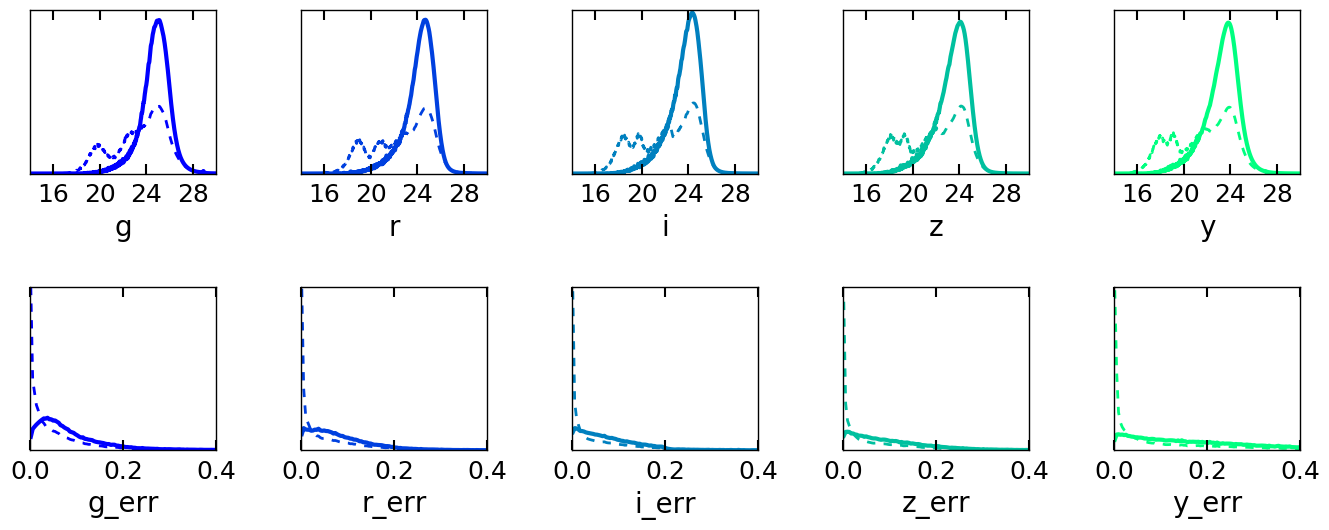

In [14]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,Nf)) # filter colors
figure(figsize=(14,6))
for i in xrange(Nf):
    subplot(2,Nf,i+1)
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,magidx[:,i],mageidx[:,i],ones(Nobs),
                            mdict.grid,mdict.delta,mdict.Ngrid)
    plot(mdict.grid,mag_pdf,lw=2,color=fcolors[i],linestyle='--')
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,magidx[:,i],mageidx[:,i],cv_weights,
                            mdict.grid,mdict.delta,mdict.Ngrid)
    plot(mdict.grid,mag_pdf,lw=3,color=fcolors[i])
    xlim([14,30])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(filt.filters[i],fontsize=20)
    tight_layout()
    subplot(2,Nf,i+1+Nf)
    h,bins=histogram(magerr_cmodel[:,i],normed=True,range=[0,0.4],bins=100)
    plot((bins[:-1]+bins[1:])/2.,h,lw=2,color=fcolors[i],linestyle='--')
    h,bins=histogram(magerr_cmodel[:,i],normed=True,range=[0,0.4],bins=100,weights=cv_weights)
    plot((bins[:-1]+bins[1:])/2.,h,lw=3,color=fcolors[i])
    xticks(linspace(0,0.4,3),fontsize=18)
    xlabel(filt.filters[i]+'_err',fontsize=20)
    yticks([])
    tight_layout()

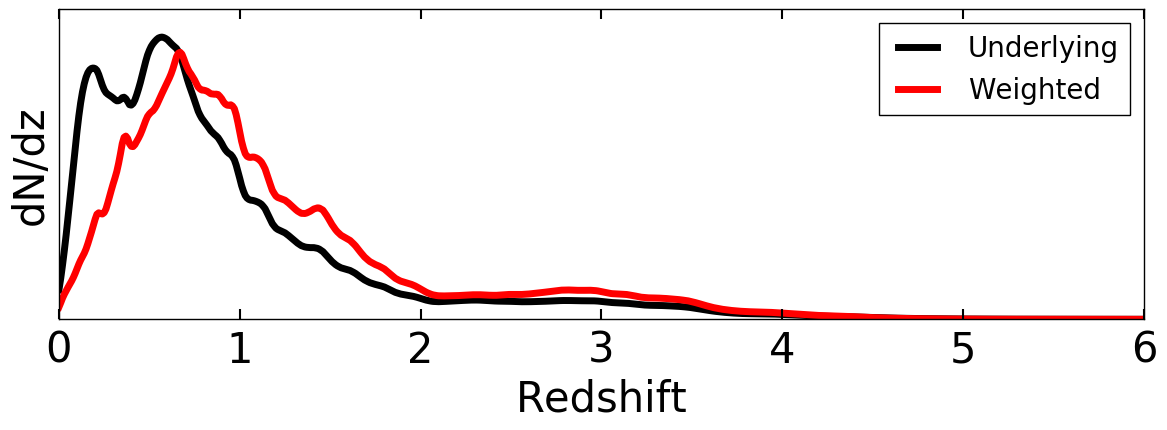

In [15]:
figure(figsize=(14,4))

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,ones(Nobs),rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='red',label='Weighted')

legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

There's clearly leftover structure in the $dN/dz$, but on the whole the basic magnitude/color weights correction looks reasonable.

## Initial Tests

We first run some initial tests using each individual set of fluxes to see which (if any) appears to perform best. Since we're just trying to gain some intuition, we'll just choose one of the original folds to run some tests on.

In [16]:
train_sel=cv<5
test_sel=cv==5
lzidx_train,lzeidx_train=lzidx[train_sel],lzeidx[train_sel]
lzidx_test,lzeidx_test=lzidx[test_sel],lzeidx[test_sel]

Ntrain=train_sel.sum()
Ntest=test_sel.sum()
print 'Ntrain:',Ntrain
print 'Ntest:',Ntest

Ntrain: 298766
Ntest: 74666


### Cmodel Fluxes

**C**omposite **model**: The total of a 2-component exponential + de Vaucouleurs fit.

In [17]:
p1,v1,m1=flux_cmodel[train_sel],square(err_cmodel[train_sel]),mask_cmodel[train_sel] # full depth
p2,v2,m2=flux_cmodel[test_sel],square(err_cmodel_wide[test_sel]),mask_cmodel[test_sel] # wide depth
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [18]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


FRANKEN-Z also contains a method to compute some PDF summary statistics.

In [19]:
# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


Let's now take advantage of some of FRANKEN-Z's built in functions to examine the results.

In [20]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Cmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Cmodel'],colors=['black','red'])

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


### PSF Fluxes

Flux as determined by fitting a PSF model.

In [21]:
p1,v1,m1=flux_psf[train_sel],square(err_psf[train_sel]),mask_psf[train_sel]
p2,v2,m2=flux_psf[test_sel],square(err_psf_wide[test_sel]),mask_psf[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [22]:
frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                            impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [23]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


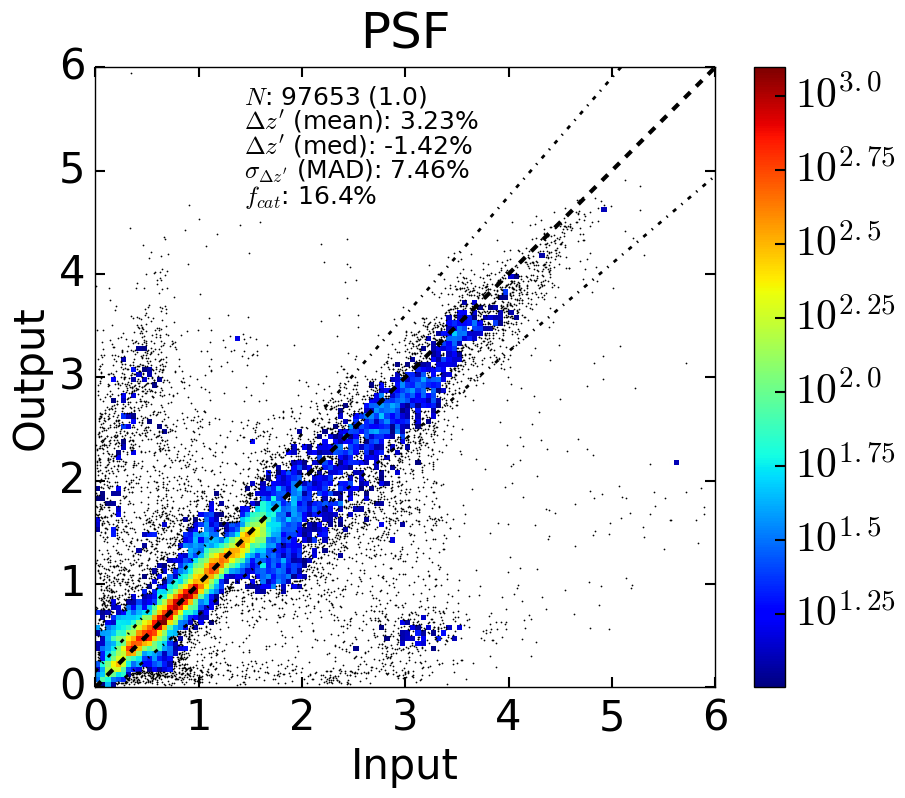

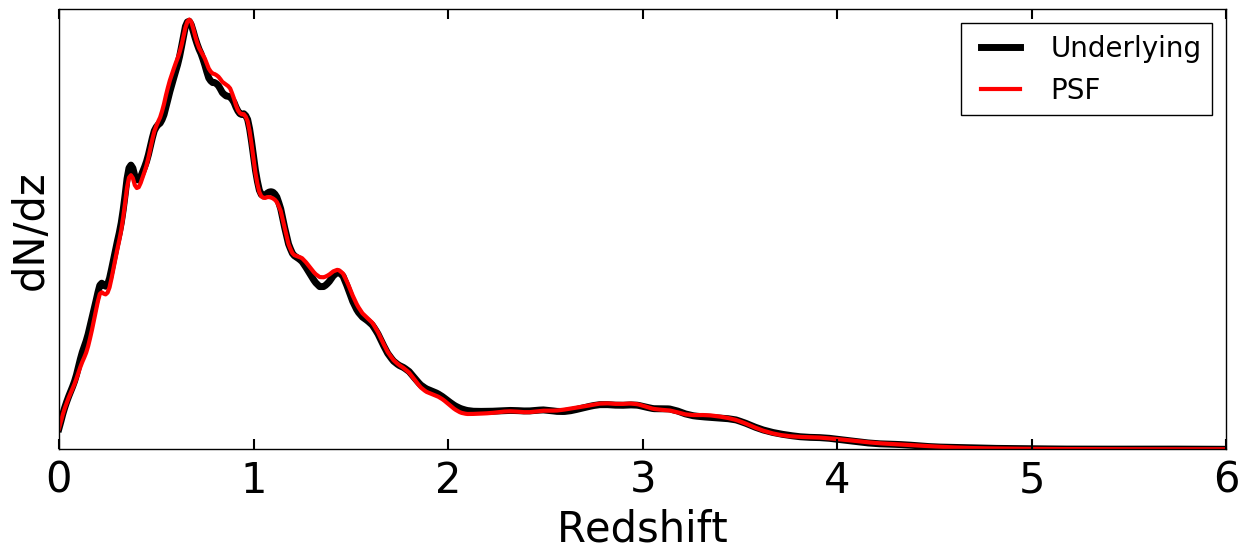

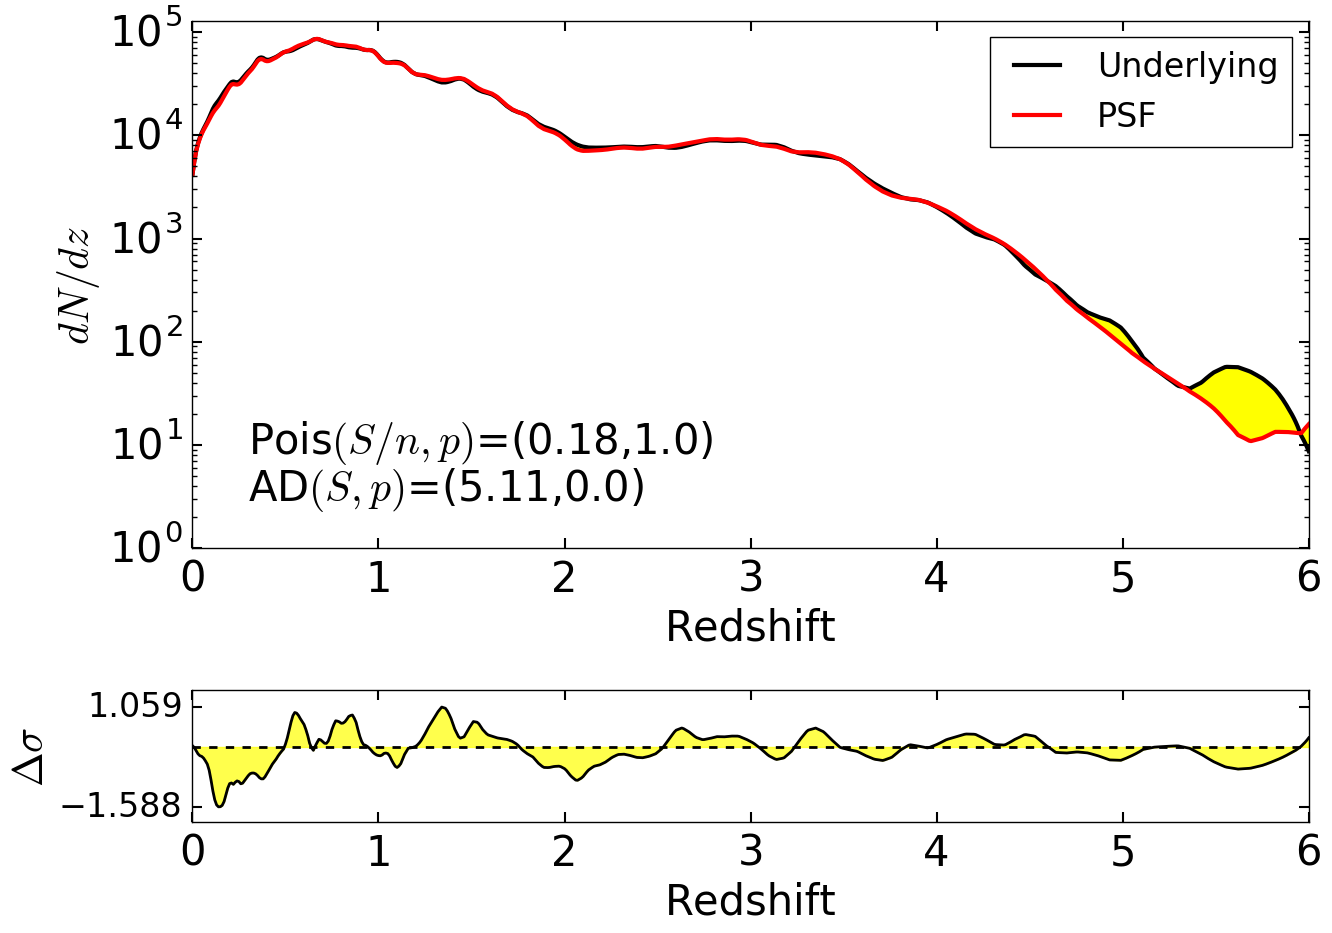

In [24]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('PSF',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='PSF')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','PSF'],colors=['black','red'])

### Cmodel Dev+Exp Fluxes

We now broaden our feature space to include each of the fitted components of the cmodel flux.

In [32]:
temp1=c_[flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_cmodel_dev,err_cmodel_exp]
temp2_wide=c_[err_cmodel_dev_wide,err_cmodel_exp_wide]
tempm=c_[mask_cmodel_dev,mask_cmodel_exp]

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),tempm[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),tempm[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [33]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


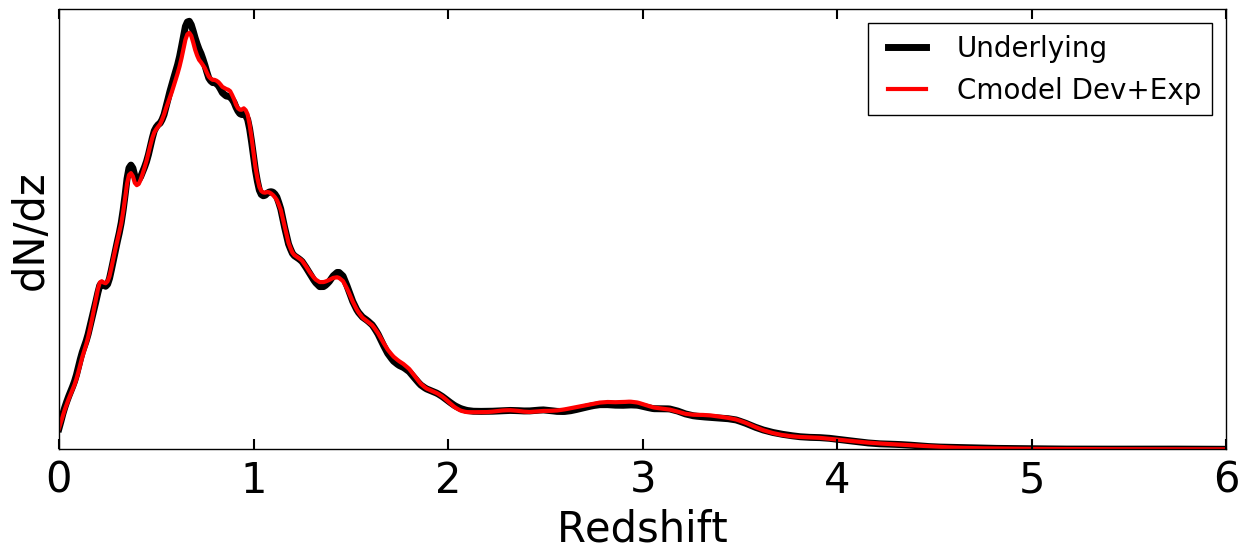

In [34]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Cmodel Dev+Exp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Cmodel Dev+Exp')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Cmodel Dev+Exp'],colors=['black','red'])

### Afterburner Fluxes

Aperture fluxes were computed during the "afterburner" run (hence the name).

In [35]:
p1,v1,m1=flux_afterburner[train_sel],square(err_afterburner[train_sel]),mask_afterburner[train_sel]
p2,v2,m2=flux_afterburner[test_sel],square(err_cmodel_wide[test_sel]),mask_afterburner[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [36]:
frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [37]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


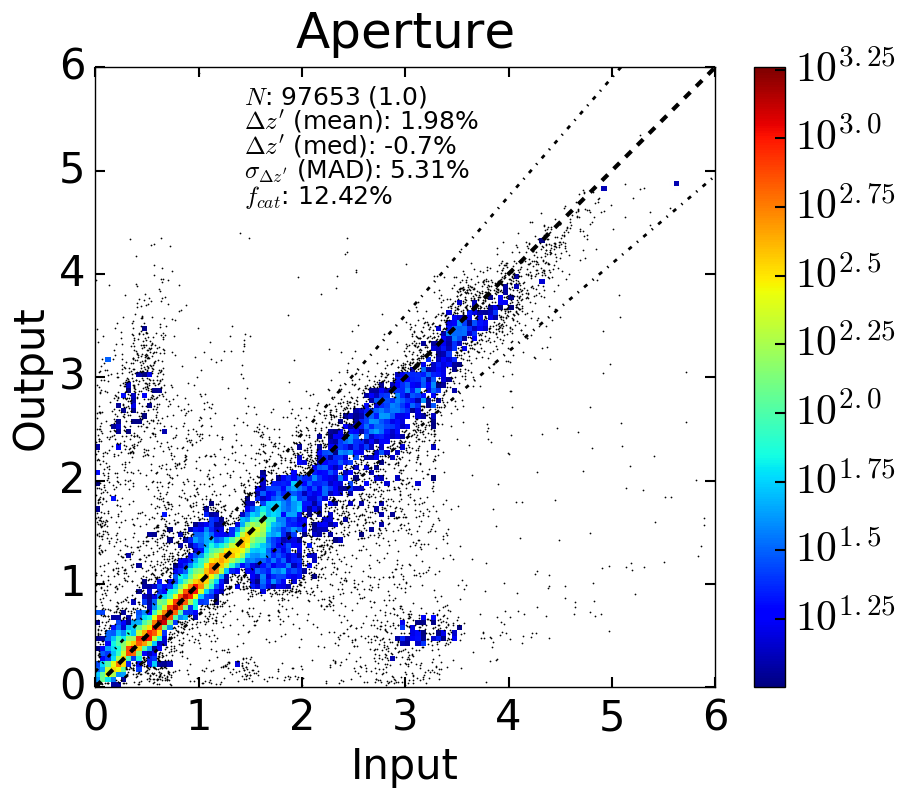

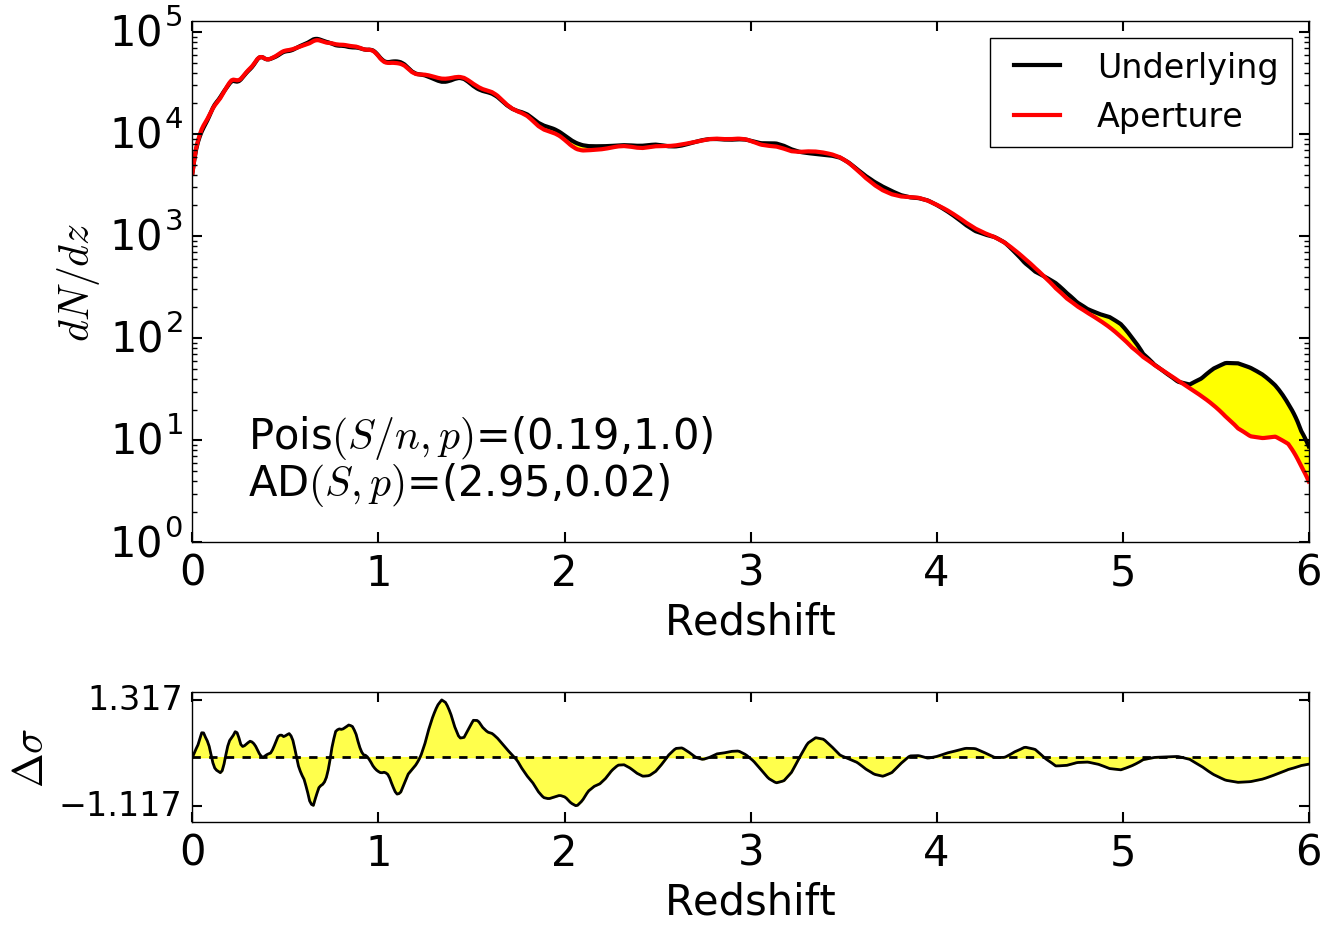

In [38]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aperture',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aperture')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aperture'],colors=['black','red'])

## Follow-Up Tests

Performance seems to go (in order): 

1. afterburner (aperture) flux
2. cmodel dev+exp flux
3. cmodel flux
4. psf flux

Now let's add together a couple of different fluxes to try and see where performance stops improving (especially since the scaling with dimensionality isn't great and we're forced to subsample features).

### Aper+Cmodel

In [39]:
temp1=c_[flux_afterburner,flux_cmodel]
temp2=c_[err_afterburner,err_cmodel]
temp2_wide=c_[err_cmodel_wide,err_cmodel_wide]
tempm=c_[mask_afterburner,mask_cmodel]
snoise=array([skynoise for i in xrange(2)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),tempm[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),tempm[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [40]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [41]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


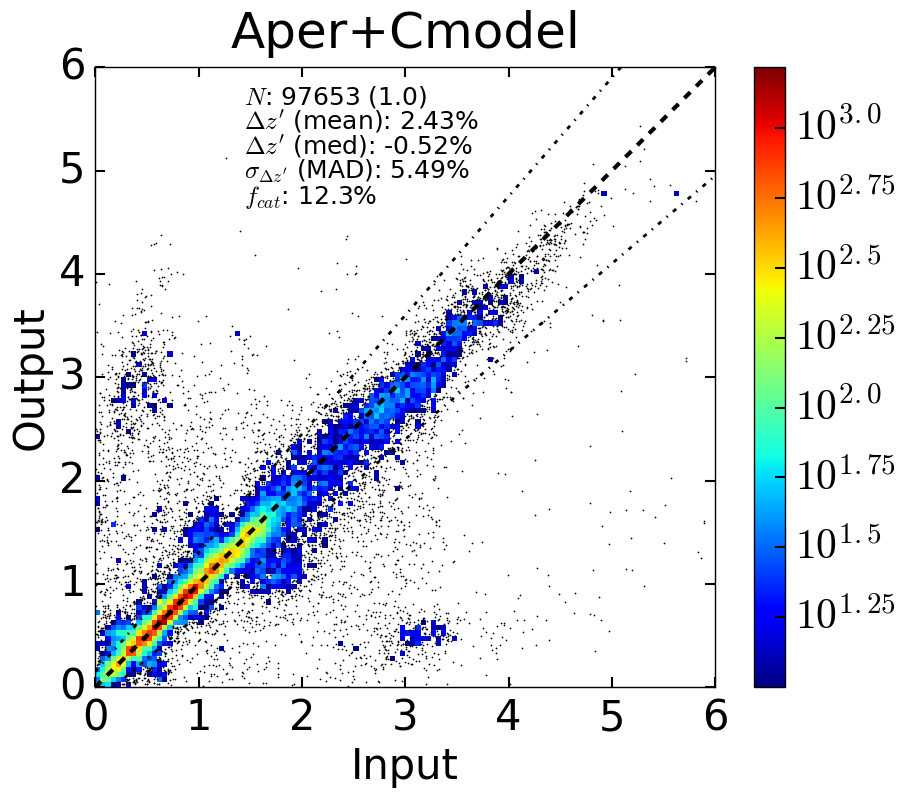

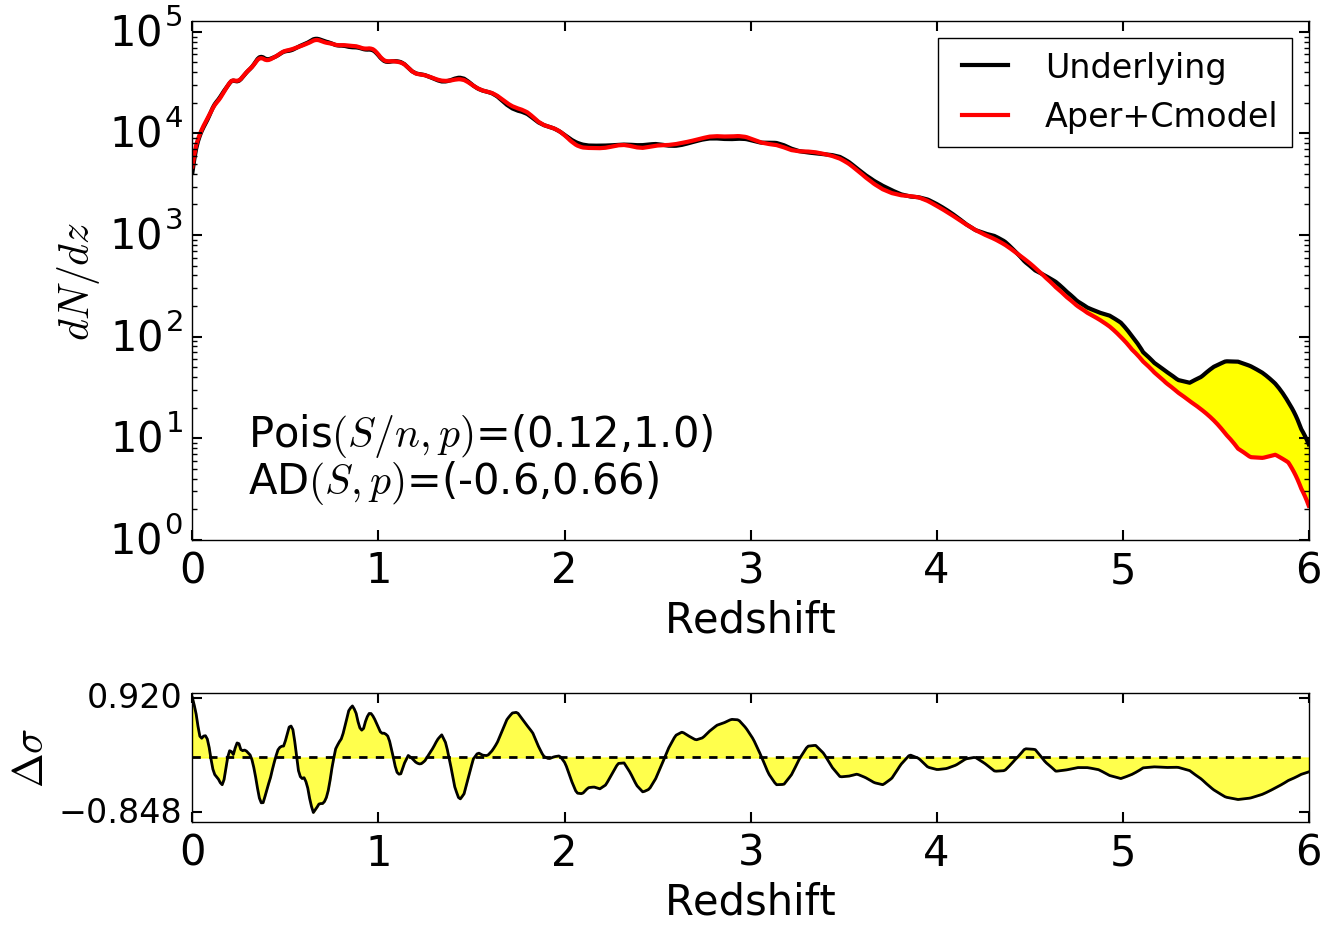

In [42]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+Cmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cmodel'],colors=['black','red'])

### Aper+Cdev+Cexp

In [43]:
temp1=c_[flux_afterburner,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner,err_cmodel_dev,err_cmodel_exp]
temp2_wide=c_[err_cmodel_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(3)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

Training/Searching a k-d tree in 15 dimensions starts to get prohibitively slow. Therefore we subsample down to 10 for each trial.

In [44]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=10,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [45]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


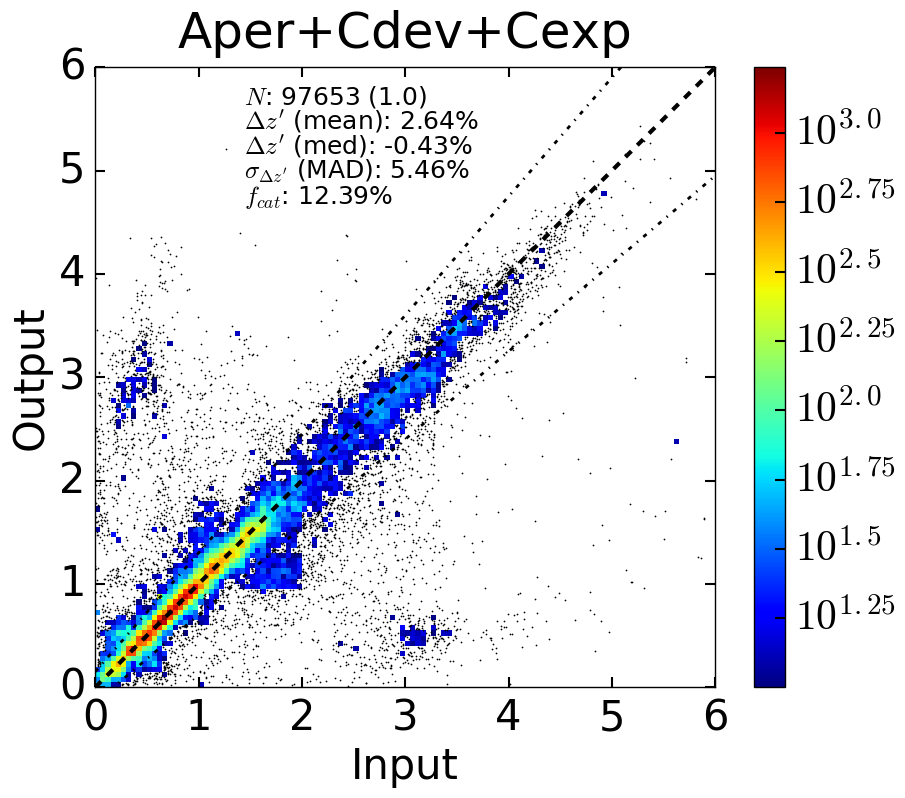

In [46]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cdev+Cexp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+Cdev+Cexp')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cdev+Cexp'],colors=['black','red'])

### Aper+PSF

In [48]:
temp1=c_[flux_afterburner,flux_psf]
temp2=c_[err_afterburner,err_psf]
temp2_wide=c_[err_cmodel_wide,err_psf_wide]
temp3=c_[mask_afterburner,mask_psf]
snoise=array([skynoise for i in xrange(2)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [49]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [50]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


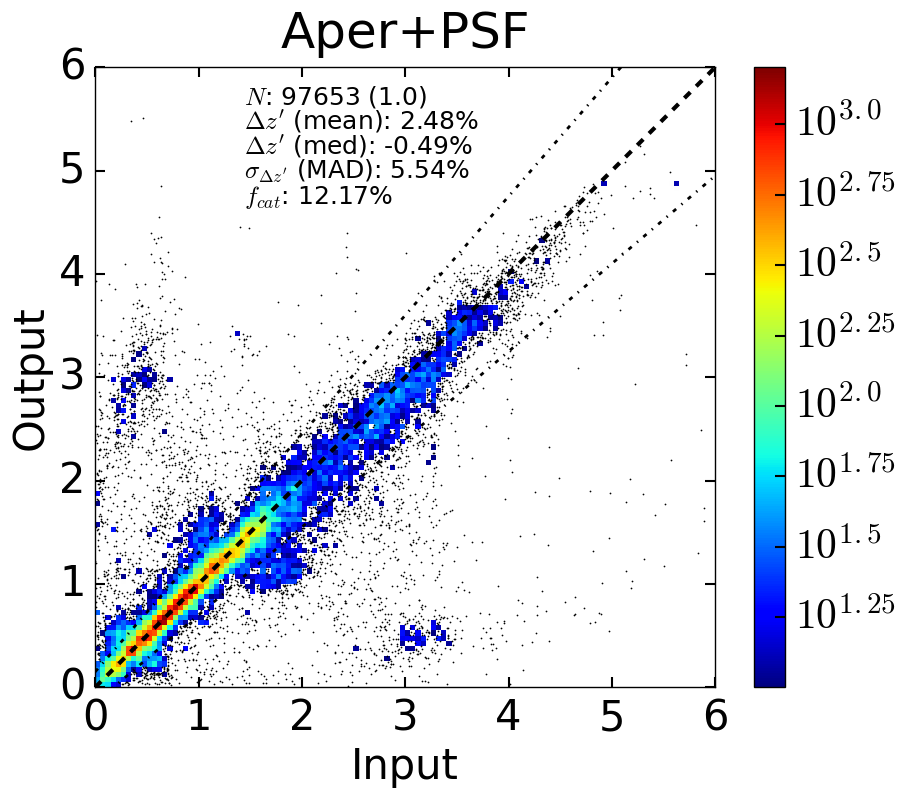

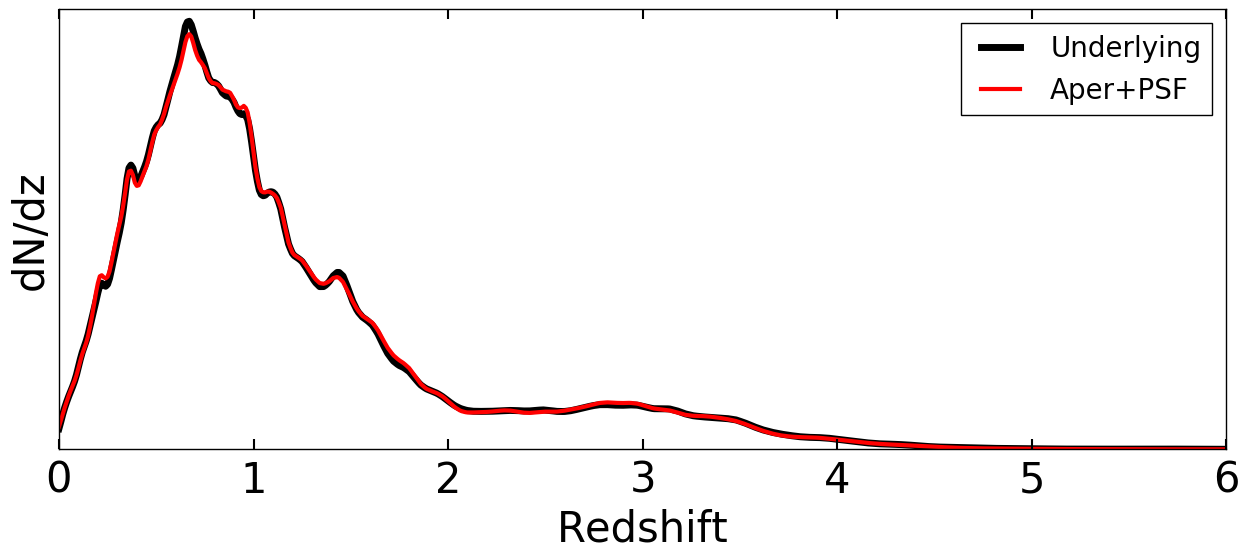

In [51]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+PSF')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF'],colors=['black','red'])

### Aper+PSF+Cdev+Cexp

In [52]:
temp1=c_[flux_afterburner,flux_psf,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner,err_psf,err_cmodel_dev,err_cmodel_exp]
temp2_wide=c_[err_cmodel_wide,err_psf_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_psf,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(4)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [53]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=10,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [54]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


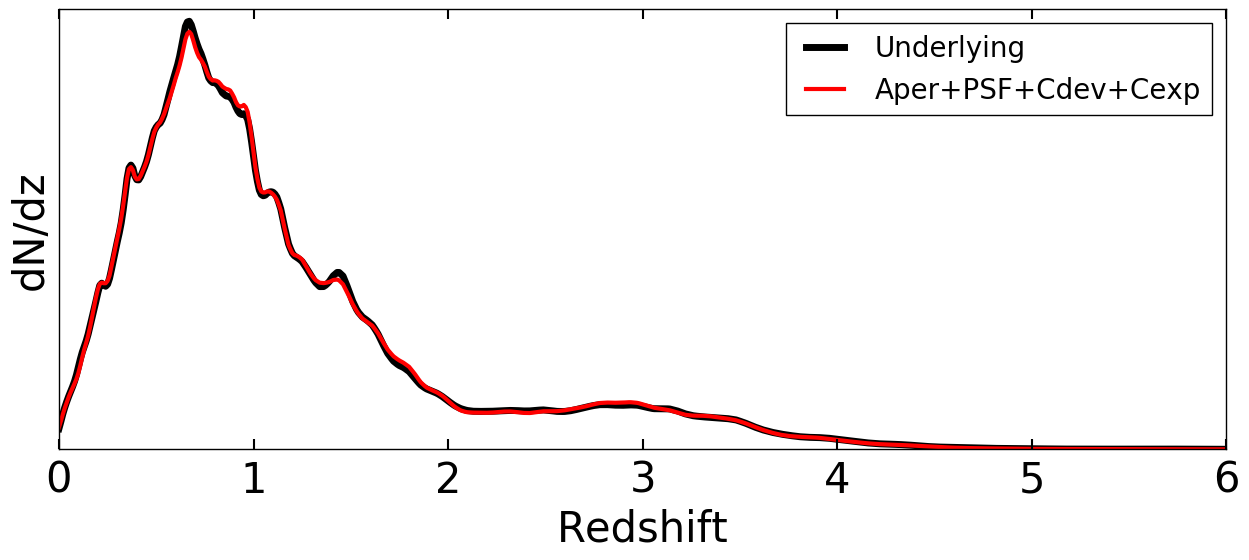

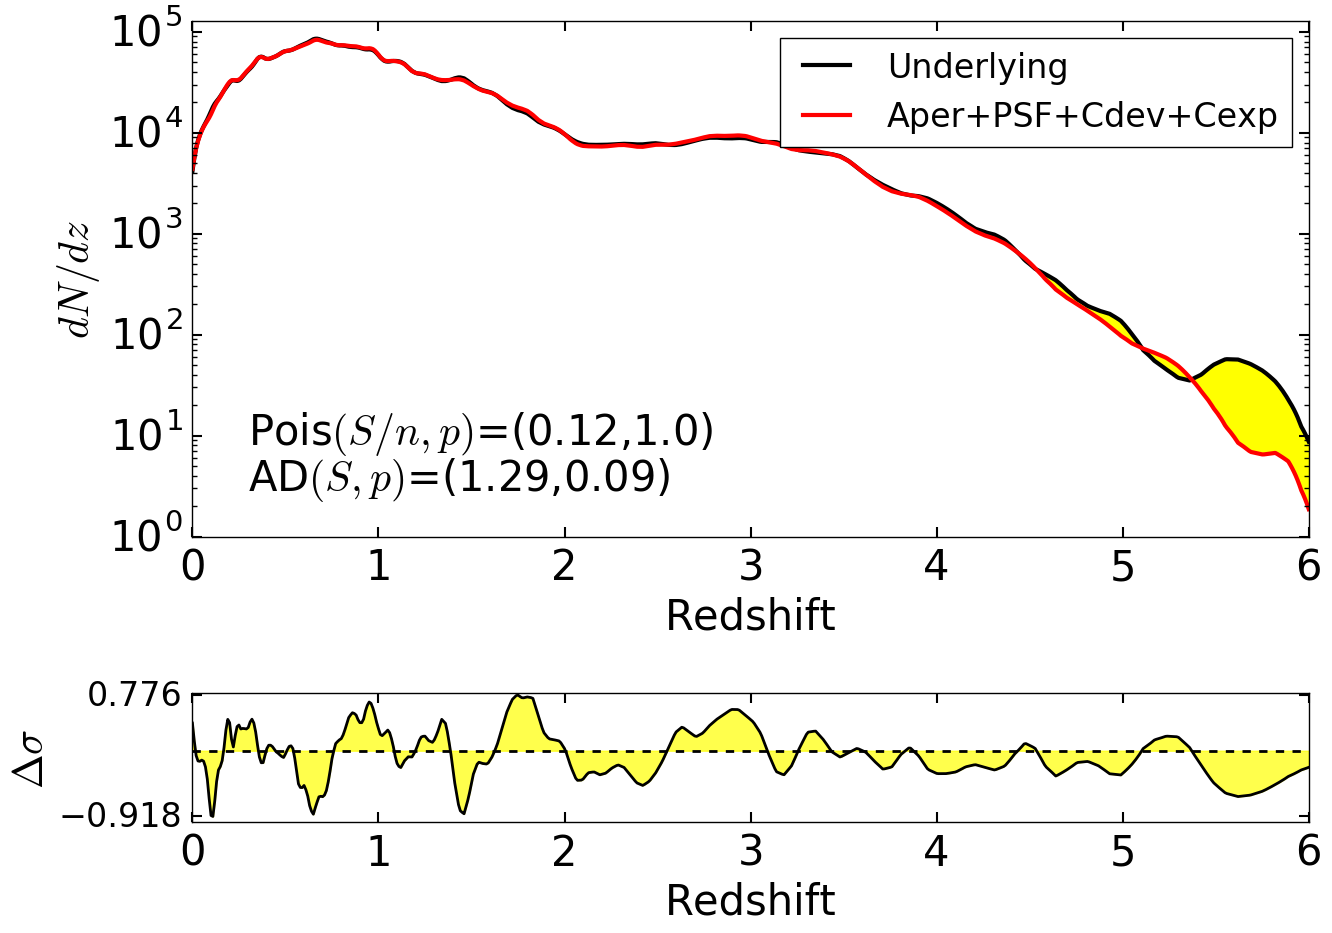

In [55]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF+Cdev+Cexp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+PSF+Cdev+Cexp')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF+Cdev+Cexp'],colors=['black','red'])

### Aper+PSF+Cdev+Cexp+Cmodel

In [60]:
temp1=c_[flux_afterburner,flux_psf,flux_cmodel_dev,flux_cmodel_exp,flux_cmodel]
temp2=c_[err_afterburner,err_psf,err_cmodel_dev,err_cmodel_exp,err_cmodel]
temp2_wide=c_[err_cmodel_wide,err_psf_wide,err_cmodel_dev_wide,err_cmodel_exp_wide,err_cmodel_wide]
temp3=c_[mask_afterburner,mask_psf,mask_cmodel_dev,mask_cmodel_exp,mask_cmodel]
snoise=array([skynoise for i in xrange(5)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [61]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=10,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [62]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


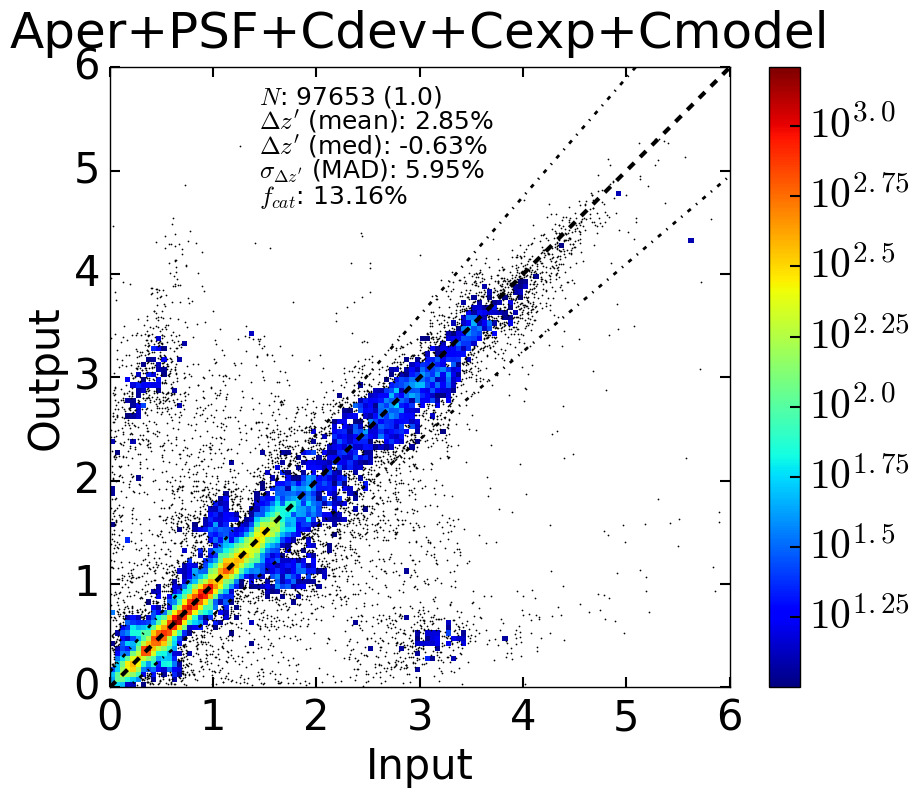

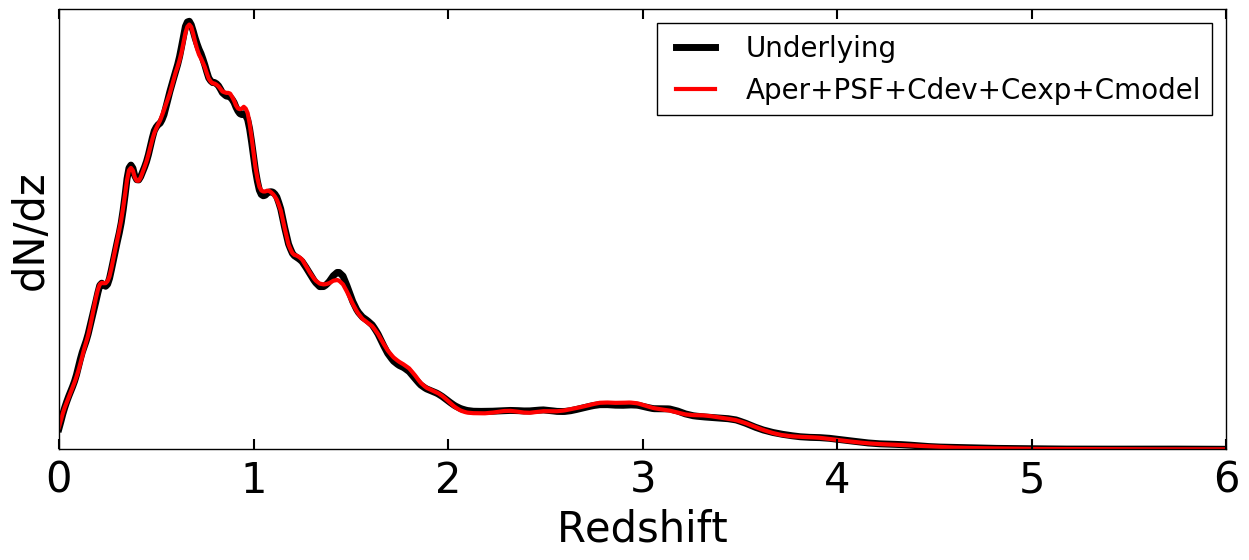

In [63]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF+Cdev+Cexp+Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+PSF+Cdev+Cexp+Cmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF+Cdev+Cexp+Cmodel'],colors=['black','red'])

## Fiducial Model

We see that adding in additional set of photometry past the aperture flux values does not seem to improve performance (likely because of a combination of adding noise and the increasing restrictiveness of our dimensionality subsampling).

In [66]:
model_obj=empty((Nobs,25*10)).astype(int)
model_Nobj=empty(Nobs).astype(int)
model_ll=empty((Nobs,25*10))
model_Nbands=empty((Nobs,25*10)).astype(int)

for i in xrange(Nfolds):
    sys.stdout.write(str(i+1)+': ')
    test_sel=cv==(i+1)
    train_sel=(test_sel==False)
    tsel=arange(Nobs)[train_sel]
    
    p1,v1,m1=flux_afterburner[train_sel],square(err_afterburner[train_sel]),mask_afterburner[train_sel]
    p2,v2,m2=flux_afterburner[test_sel],square(err_cmodel_wide[test_sel]),mask_afterburner[test_sel]
    e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

    mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
    mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

    # initialize WINBET instances
    winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET
    if (m1==False).sum()>0:
        winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
    else:
        winbet_train=None
    if (m2==False).sum()>0:
        winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
    else:
        winbet_test=None

    frankenz=fz.FRANKENZ(N_members=25)
    temp=frankenz.predict(p1,e1,m1,p2,e2,m2,impute_train=winbet_train,impute_test=winbet_test)
    model_obj[test_sel],model_Nobj[test_sel],model_ll[test_sel],model_Nbands[test_sel]=temp
    model_obj[test_sel]=tsel[model_obj[test_sel]] # re-indexing to match full training data (not subsample)

1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 0 9 0 10 0 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 0 19 0 20 0 21 0 22 0 23 0 24 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
2: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 0 9 0 10 0 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 0 19 0 20 0 21 0 22 0 23 0 24 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
3: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
4: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 2

Before we move on, let's just dump these files to disk.

In [67]:
save('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_obj',model_obj)
save('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_Nobj',model_Nobj)
save('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_ll',model_ll)
save('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_Nbands',model_Nbands)

In [14]:
model_obj=load('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_obj.npy')
model_Nobj=load('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_Nobj.npy')
model_ll=load('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_ll.npy')
model_Nbands=load('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cv_Nbands.npy')

Let's now take a look at our redshift performance.

In [15]:
# generate redshifts
model_llmin=empty(Nobs).astype(float)
lzpdf=empty((Nobs,rdict.Nz))
zpdf=empty((Nobs,rdict.Nz_out))
model_levidence=empty(Nobs)

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx[midx],lzeidx[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360

In [16]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aperture',z,zpoints[1],weights=cv_weights)

(array([-0.02553435,  0.5146221 ,  0.02153512,  0.26860043]),
 array([-0.00680053,  0.11434531, -0.00835872,  0.05326608], dtype=float32),
 0.127368400281302)

Our performance on the wide-depth weighted sample looks pretty reasonable all things considered.

(array([-0.01042746,  0.21635061,  0.00225593,  0.11241837]),
 array([-0.00699627,  0.0611012 , -0.00684351,  0.03255058], dtype=float32),
 0.050725051661978403)

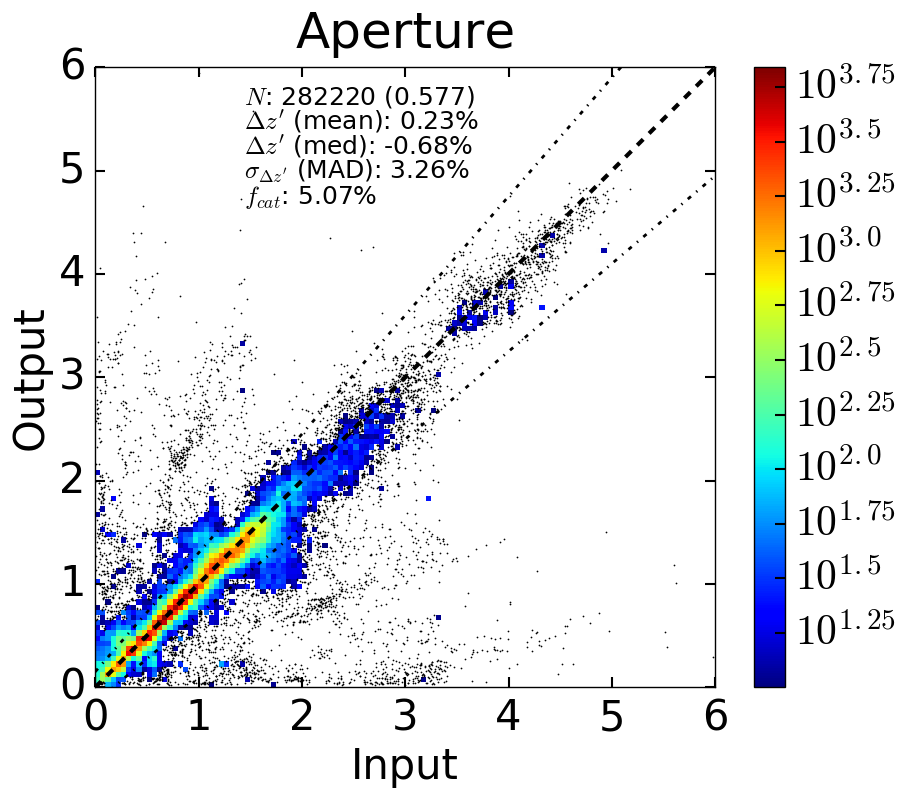

In [17]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aperture',z,zpoints[1],weights=cv_weights,selection=zpoints[-2]/(1+zpoints[1])<0.15)

Our PDFs also look quite reasonable, so that after a basic cut we can significantly reduce the relative fraction of outliers.

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


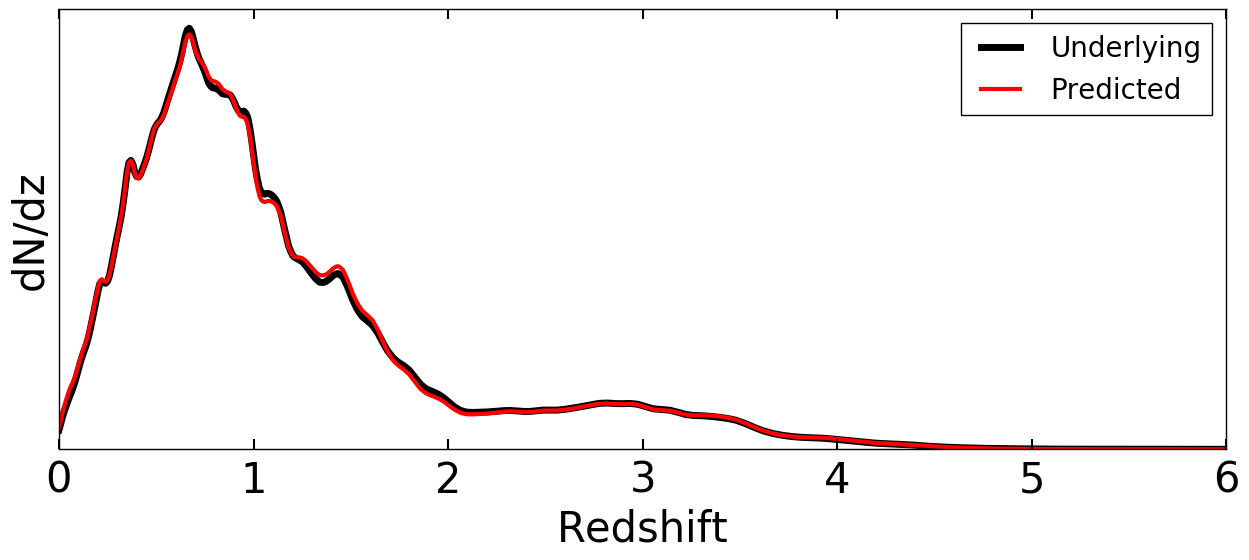

In [18]:
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[:,None],axis=0)/cv_weights.sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights.sum(),nz_stack*cv_weights.sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aperture'],colors=['black','red'])

Our $dN/dz$ reconstruction also looks very good.

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 Computing PDF quantities...0 done!
Resampling PDFs...0 done!


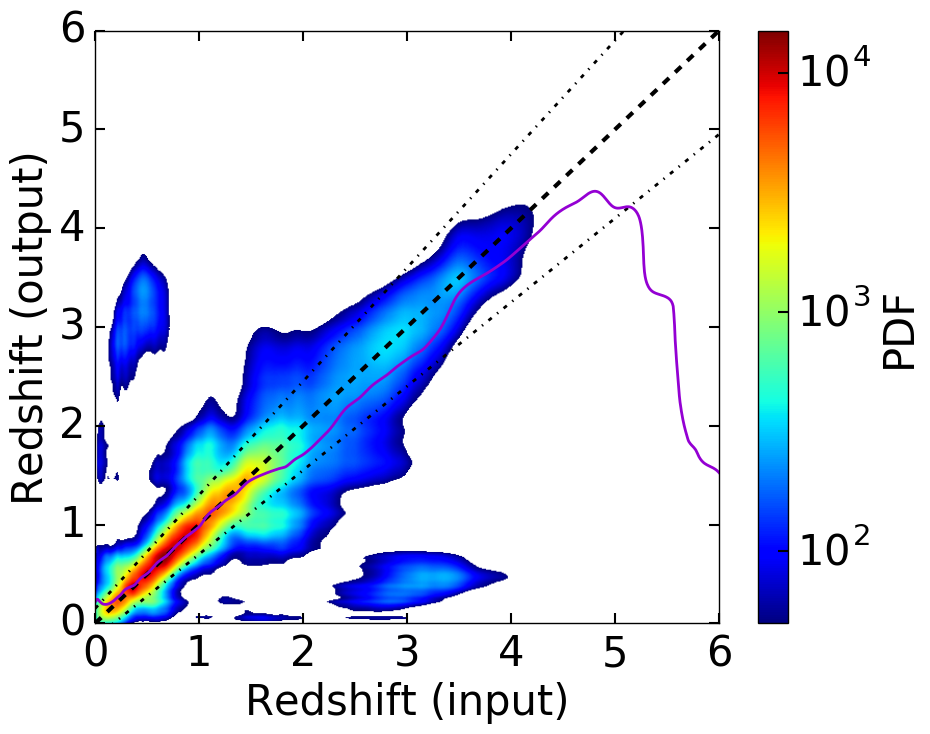

In [19]:
figure(figsize=(10,8))
z2dstack,z2dprob,z2dpoints=fz.plot_zpdfstack(zpdf,rdict.zgrid_out,lzidx,lzeidx,rdict,weights=cv_weights)

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 Computing PDF quantities...0 done!


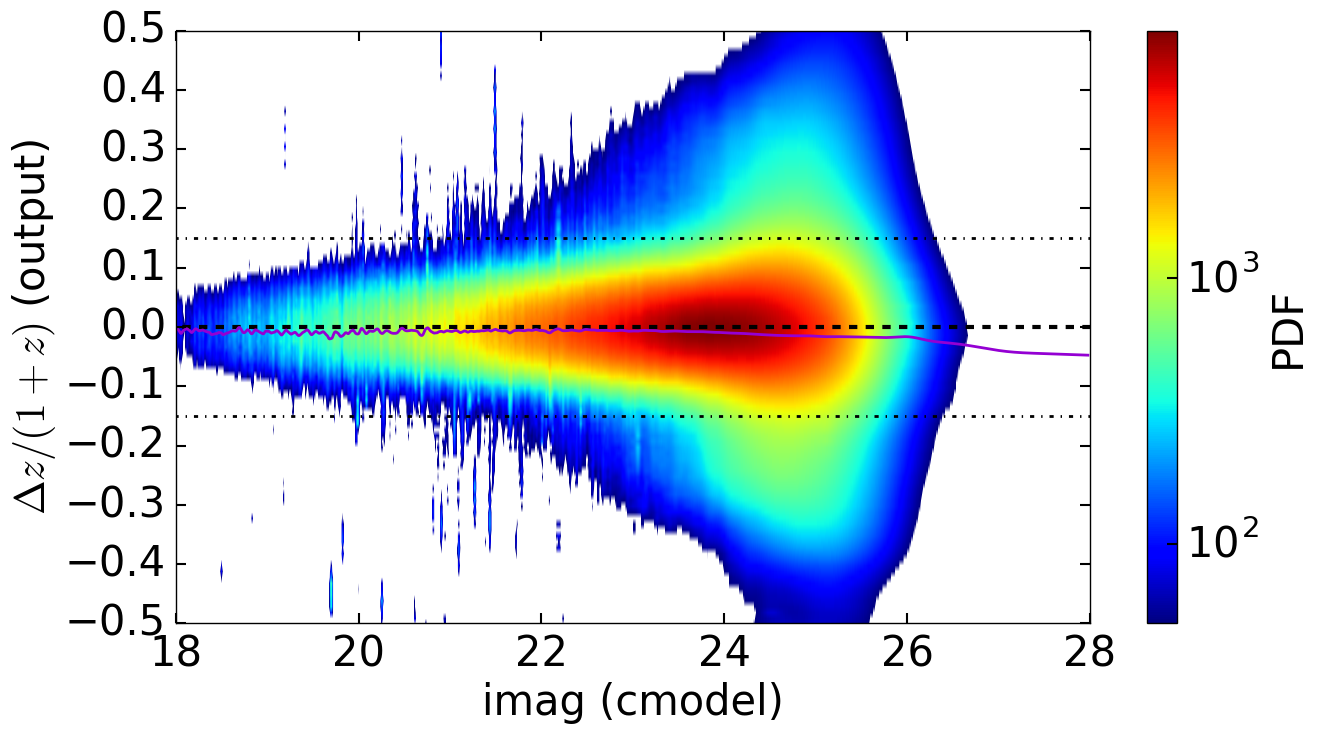

In [20]:
figure(figsize=(14,8))
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,z,magidx[:,2],mageidx[:,2],mdict,
                                          [18,28,2.],'imag (cmodel)',weights=cv_weights,boxcar=10)

Our stacked PDFs also show very good behavior and performance, although things do start to blow up below 24th mag or so.

Let's now check how our fits break down by redshift type.

In [21]:
# compute Ntype and Ptype
model_Ntype=zeros((Nobs,3))
model_Ptype=zeros((Nobs,3))

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    ztypes=zt[midx]-1
    like=exp(-0.5*(ll-model_llmin[i]))
    like/=like.sum()
    for j in xrange(Nm):
        model_Ntype[i][ztypes[j]]+=1
        model_Ptype[i][ztypes[j]]+=like[j]

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 

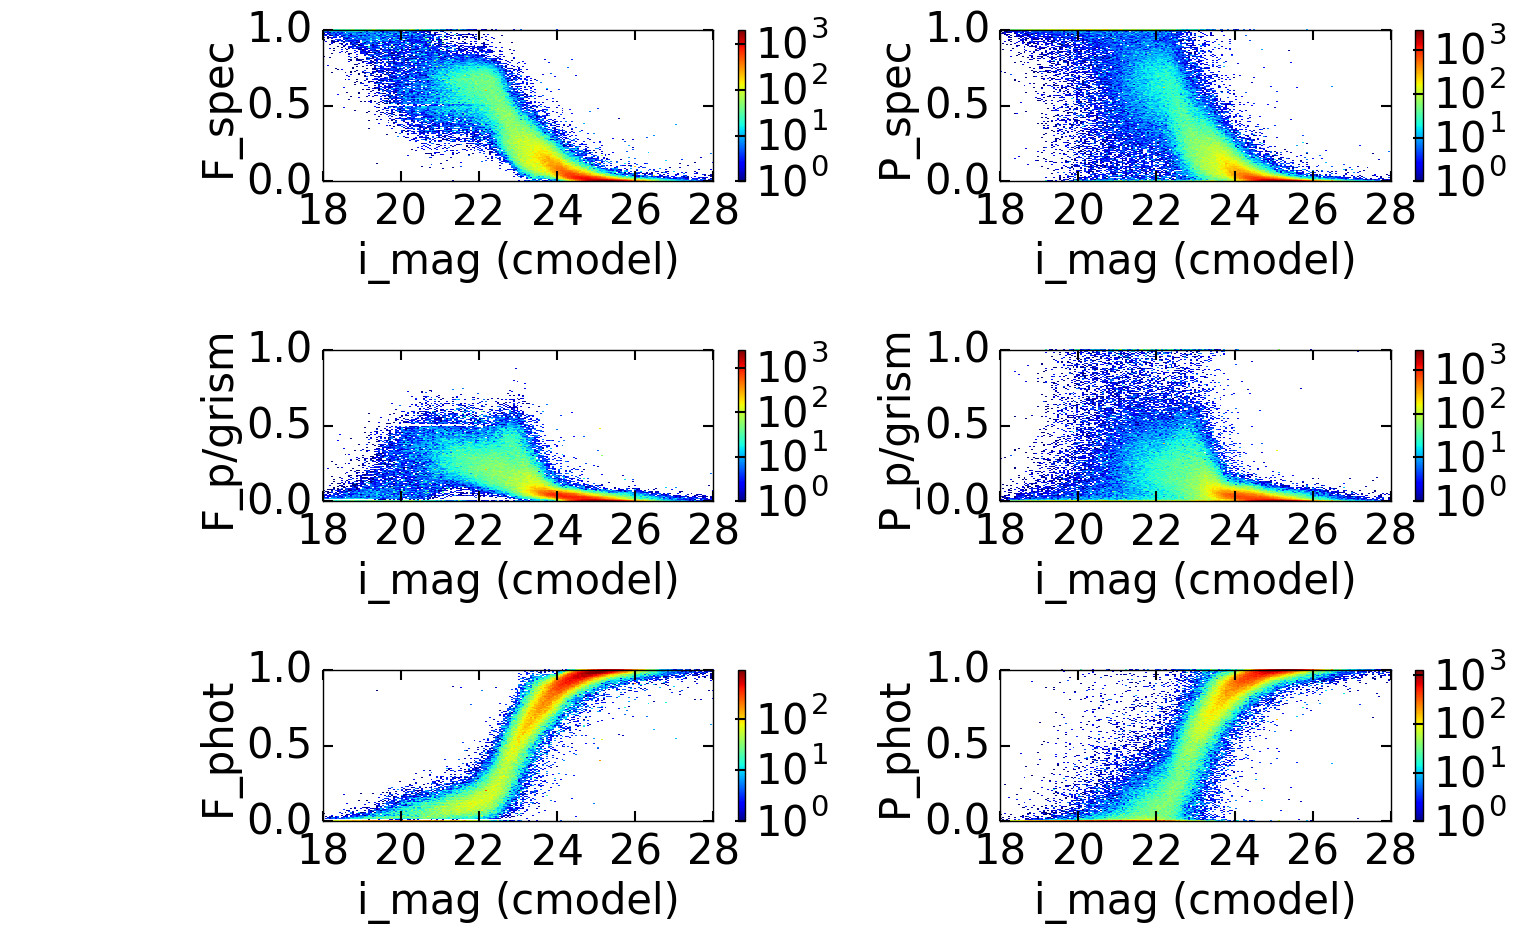

In [22]:
figure(figsize=(14,10))
subplot(3,2,1)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,0]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_spec')
tight_layout()
subplot(3,2,2)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,0],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_spec')
tight_layout()
subplot(3,2,3)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,1]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_p/grism')
tight_layout()
subplot(3,2,4)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,1],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_p/grism')
tight_layout()
subplot(3,2,5)
h=hist2d(mag_cmodel[:,2],model_Ntype[:,2]/model_Ntype.sum(axis=1),bins=[arange(10,30,0.05),linspace(0,1,200)],
         norm=matplotlib.colors.LogNorm(),weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('F_phot')
tight_layout()
subplot(3,2,6)
h=hist2d(mag_cmodel[:,2],model_Ptype[:,2],bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),
         weights=cv_weights,cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag (cmodel)')
ylabel('P_phot')
tight_layout()

As we expect, photo-z's tend to dominate the neighbors and likelihood fraction at faint magnitudes, with a sharp transition between 22nd and 24th mag.

## Incorporating Selection Effects

The HSC survey pipeline extracts photometry for objects if they are **detected at 5-$\sigma$ in *any* band**. We can write this as the complement of *not* detecting an object at 5-$\sigma$ in *all* bands, which gives

\begin{equation}
P(\gamma|g) = 1-\prod_i \Phi(5\hat{\sigma}_{g,i}|\hat{F}_g,\hat{\sigma}_{g,i}) = 1-\prod_i \frac{1}{2}\textrm{erfc}\left[ \left(\hat{F}_{g,i}-5\hat{\sigma}_{g,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right]
\end{equation}

where the product over $i$ is taken over all relevant bands. Although we won't be using this correction here since we'll be running FRANKEN-Z over the entire catalog, this will be relevant when computing/modifying photo-z's to specific data subsets (such as weak lensing-selected data). We provide a quick illustration of this below for cmodel photometry.

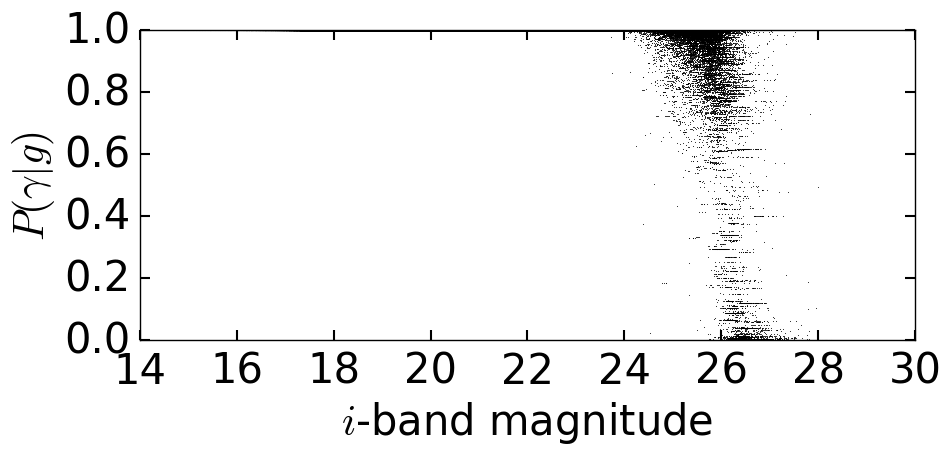

In [45]:
phot_sel=1-prod(0.5*special.erfc((flux_cmodel-5*err_cmodel_wide)/(sqrt(2)*err_cmodel_wide)),axis=1)

figure(figsize=(10,4))
plot(mag_cmodel[:,2],phot_sel,'.',color='black',markersize=0.5)
xlabel('$i$-band magnitude')
ylabel('$P(\gamma|g)$')

$P(\gamma|h)$ can be written as

\begin{equation}
P(\gamma|h) = \int P(g|h)P(\gamma|g) dg \propto 1 - \prod_{i=1}^n \frac{1}{2} \int \mathcal{N}(\hat{F}_{g,i}|\hat{F}_{h,i},\hat{\sigma}^2_{h,i}+\hat{\sigma}^2_{g,i}) \, \textrm{erfc}\left[ \left(\hat{F}_{g,i}-5\hat{\sigma}_{g,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] d\hat{F}_{g,i}
\end{equation}

This cannot be evaluated analytically, but can be approximated numerically using a series of Monte Carlo fluxes drawn from the observed flux distribution $\lbrace\mathbf{\hat{F}}_g^1,\mathbf{\hat{F}}_g^2,\dots,\mathbf{\hat{F}}_g^n\rbrace \sim \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{\hat{F}}_{h},\mathbf{\hat{C}}_{h}+\mathbf{\hat{C}}_{g})$ via

\begin{equation}
P(\gamma|h) \approx 1- \prod_i \left( \frac{1}{2N} \sum_{t=1}^{N} \textrm{erfc}\left[ \left(\hat{F}^t_{g,i}-F_{cut,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] \right).
\end{equation}

Again, we will not be evaluating this here.

## Hierchical Modification

Now let's check how well we can derive errors on our $dN/dz$ distribution using our previous hierarchical models. Let's set our population prior $P(\mathbf{f^h})$ and initialize our population parameter vector $\mathbf{f}^{\mathbf{h}}_0$.

In [56]:
p_fh=ones(Nobs)/Nobs # uniform prior

In [57]:
fh=zeros(Nobs)
model_llmin=empty(Nobs) # min(log-likelihood)

for i in xrange(Nobs):
    Nm=model_Nobj[i] # number of models
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm] # model indices and corresponding log-likelihoods
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # weights
    weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
    weights*=p_fh[midx] # multiply by global prior
    weights/=weights.sum() # normalize
    fh[midx]+=weights # stack

Now that everything's all set up, we generate a bunch of $\mathbf{f^h}$ samples.

In [62]:
N_samples=100
fh_t=zeros((N_samples,len(fh)))

# Gibbs sampler
fh_t[0]=fh # initialize

for i in xrange(N_samples-1):
    sys.stdout.write(str(i)+' ')
    fh_i=random.dirichlet(fh_t[i]+1) # draw population
    for j in xrange(Nobs):
        Nm=model_Nobj[j] # number of models
        midx,ll,llmin=model_obj[j][:Nm],model_ll[j][:Nm],model_llmin[j]
        weights=exp(-0.5*(ll-llmin))
        weights[isfinite(weights)==False]=0 # assign failed computations (nan,inf) 0 weight
        weights*=fh_i[midx]*p_fh[midx] # (P(pop_global)*P(pop_conditional)*likelihood)
        fh_t[i+1][midx]+=weights/weights.sum()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

As with standard Metropolis-Hastings Markov Chain Monte Carlo (MCMC) sampling, we first have to guarantee our sampler converges before we begin drawing values to derive a joint PDF. Starting at 20 appears reasonable.

([], <a list of 0 Text yticklabel objects>)

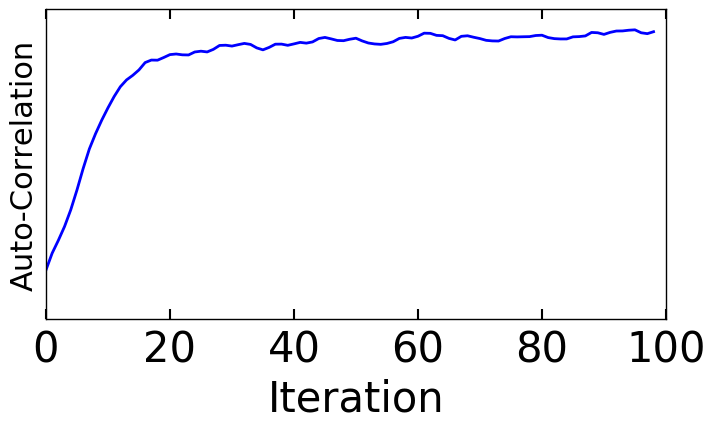

In [67]:
figure(figsize=(8,4))
plot([correlate(fh_t[i+1],fh_t[i]) for i in xrange(N_samples-1)],color='blue',lw=2)
xlabel('Iteration')
ylabel('Auto-Correlation',fontsize=22)
yticks([])

**Important sidenote**: To properly condition a covariance/precision matrix, we need as many samples as "free parameters". This means we're limited by the resolution of our grid, and that saving on computation time using fewer samples will require downsampling our redshift, mass, etc. grid to coarser resolution using, e.g., binning.

In [78]:
N_burnin=20 # burn-in trials
z_pdf_draws=empty((N_samples-N_burnin,rdict.Nz_out)) # dn/dz draws

for i in xrange(N_burnin,N_samples):
    sys.stdout.write(str(i)+': ')
    midx=choice(Nobs,p=fh_t[i]/fh_t[i].sum(),size=Nobs) # sample from f^h
    temp1,temp2,temp3=lzidx[midx],lzeidx[midx],cv_weights[midx]
    pz=zeros(rdict.lzgrid_highres.shape)
    for j in xrange(Nobs):
        if j%20000==0: sys.stdout.write(str(j/20000)+' ')
        t1,t2,t3=temp1[j],temp2[j],temp3[j]
        w,k=rdict.sig_width[t2],rdict.sig_dict[t2]
        pz[choice(xrange(t1-w,t1+w+1),p=k/k.sum())]+=t3
    pz=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    pz=interp(rdict.zgrid_out,rdict.zgrid,pz)
    pz/=pz.sum()
    z_pdf_draws[i-N_burnin]=pz
z_pdf_draws_mean=z_pdf_draws.mean(axis=0)
z_pdf_draws_mean/=z_pdf_draws_mean.sum()

20 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 21 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 22 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 25 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 26 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 28 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 30 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 33 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 35 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 36 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 37 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 38 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 39 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

Let's finally compare the difference between the original $dN/dz$ and the hierarchical Gibbs draws.

In [79]:
figure(figsize=(14,6))

plot(rdict.zgrid_out,zeros(rdict.Nz_out),lw=2,color='red',alpha=0.5,label='Sample')
[plot(rdict.zgrid_out,z_pdf_draws[i],lw=2,color='red',alpha=0.05) for i in xrange(N_samples-N_burnin)]

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

plot(rdict.zgrid_out,nz_stack,lw=3,color='blue',label='Original')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
tight_layout()
legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('Normalized Density')

In [83]:
figure(figsize=(14,10))
Q_pois,Q_ad,Q_err=fz.plot_nz(z_pdf*int(cv_weights.sum()),z_pdf_draws_mean*int(cv_weights.sum()),
                             rdict.zgrid_out,rdict.dz_out,
                             out_nz_draws=z_pdf_draws*int(cv_weights.sum()),
                             sample_names=['Underlying','Hierarchical Bayes'],colors=['black','red'])

That looks good to me!